# Partial Fourier Transform 
Computations and practice

In [90]:
from numpy import *
import matplotlib.pyplot as plt
%matplotlib notebook
from scipy.linalg import block_diag
import scipy.sparse as ss
import scipy.sparse.linalg as ssl

In [140]:
import warnings
warnings.filterwarnings('ignore')

## 1D chain

Take the simple 1D model with 

$$\begin{equation}
H = -t \sum_{j} c^{\dagger}_{j+1} c_{j} + c^{\dagger}_{j} c_{j+1}
\end{equation}$$

Here we assume periodic boundary conditions.

By Fourier transforming we know that $E_k = -2t \cos(k)$.

<IPython.core.display.Javascript object>


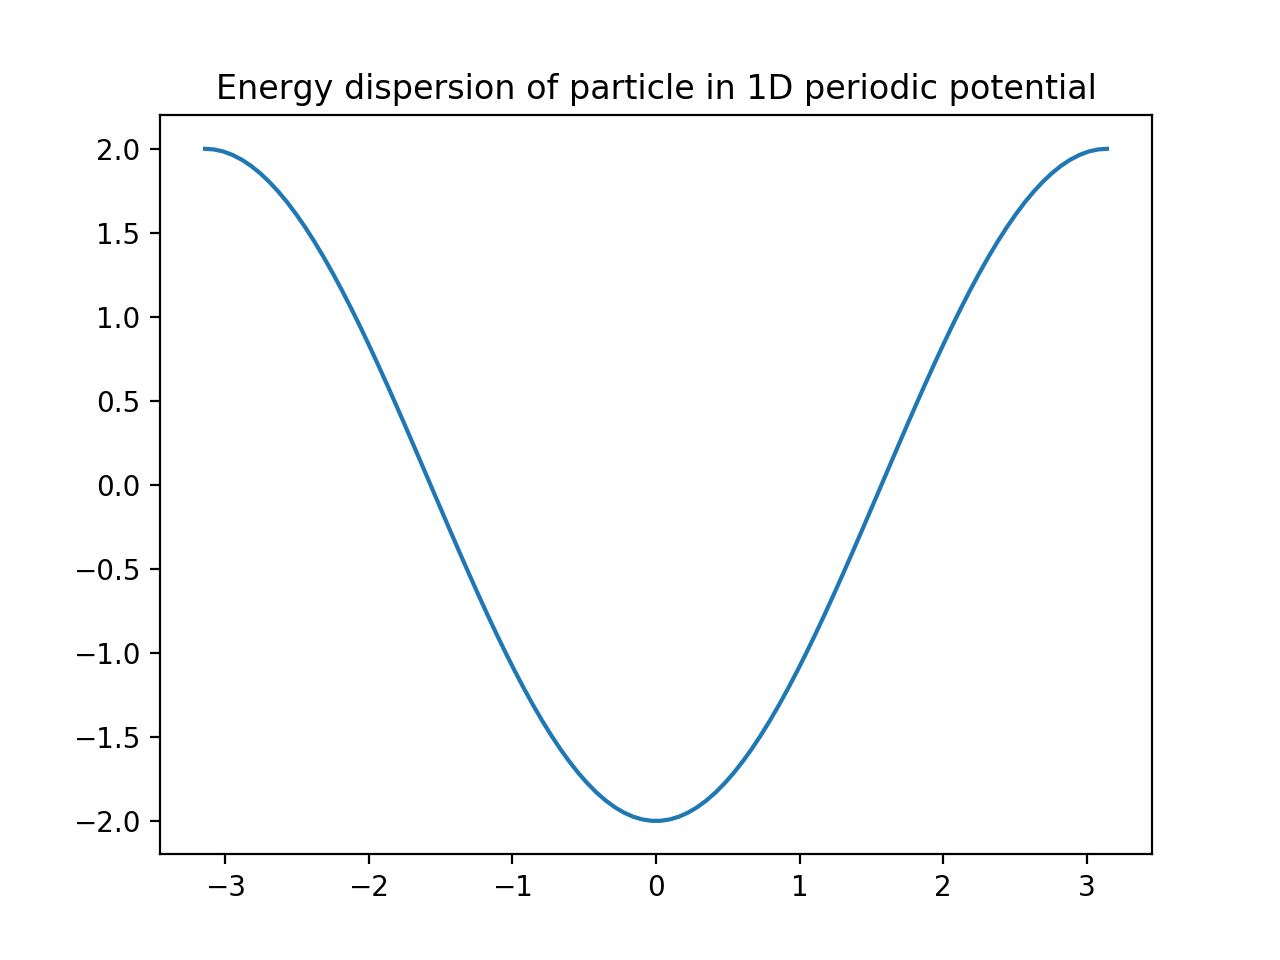

<IPython.core.display.Javascript object>


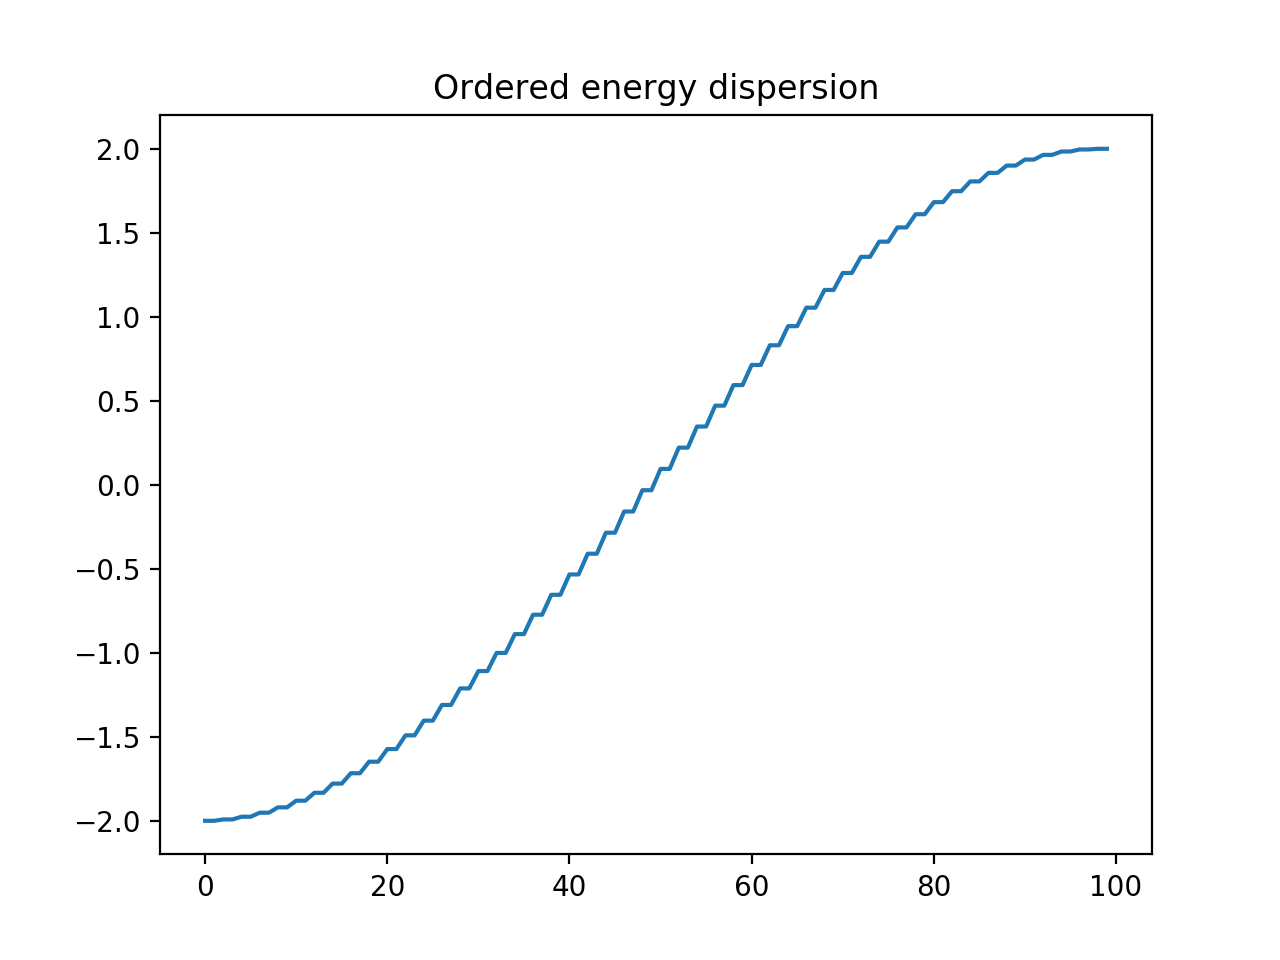

In [35]:
ks = linspace(-np.pi,np.pi,100,endpoint=True)
E_k = -2 * cos(ks)

plt.figure()
plt.title("Energy dispersion of particle in 1D periodic potential")
plt.plot(ks, E_k)
plt.show()

plt.figure()
plt.title("Ordered energy dispersion")
plt.plot(np.linspace(0,len(E_k),len(E_k), endpoint = False), sort(E_k))
plt.show()

Let's see if we can get this same (sorted) dispersion without fourier transforming, i.e. in real space algebra.

In [11]:
def H_mat_1D(size, t = 1):
    size = int(size)
    H_off_diag_up = diag(-t*ones(size-1),k=1)
    H_off_diag_down = diag(-t*ones(size-1),k=-1)
    H = H_off_diag_down + H_off_diag_up
    H[0,size-1] = -t
    H[size-1,0] = -t
    return H

<IPython.core.display.Javascript object>


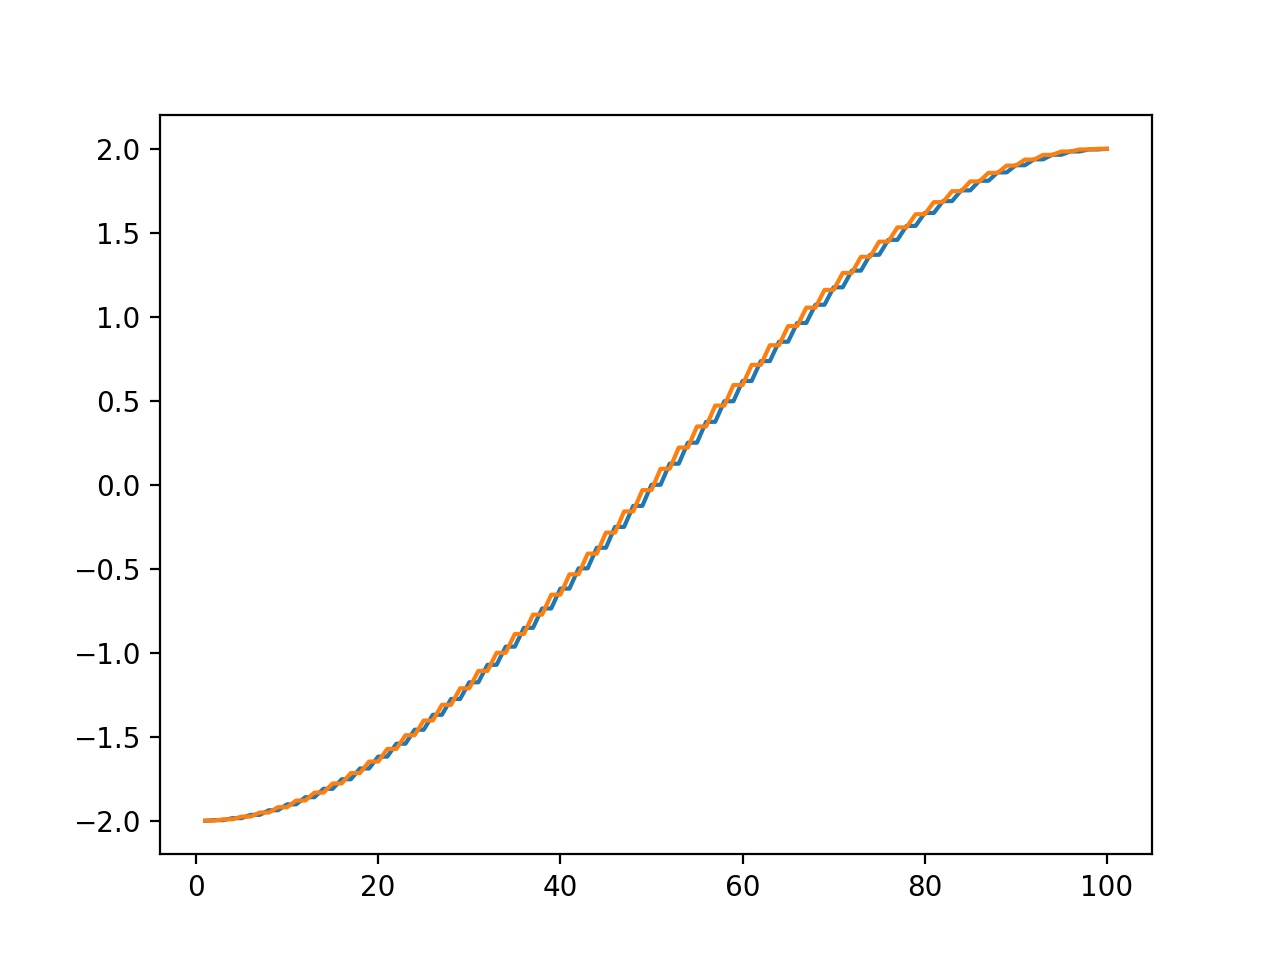

In [38]:
N = 100
H = H_mat_1D(size=N)
eigs = linalg.eigvalsh(H)
ns = linspace(1,len(eigs),len(eigs), endpoint = True)

plt.figure()
plt.plot(ns, eigs)
plt.plot(np.linspace(1,len(E_k),len(E_k), endpoint = True), sort(E_k))
plt.show()

The boundary $t$'s cause the step-like appearance. Looks the same! However, we lose some information as to the form of the plot $k \text{ vs } E$

Can we recover $k$'s from `ns`?

In [42]:
k_rec = zeros(len(ns))

for i in range(len(ns)):
    n = ns[i]
    n_new = ceil(n/2)
    k_rec[i] = (-1)**n * n_new * 2*pi / N

<IPython.core.display.Javascript object>


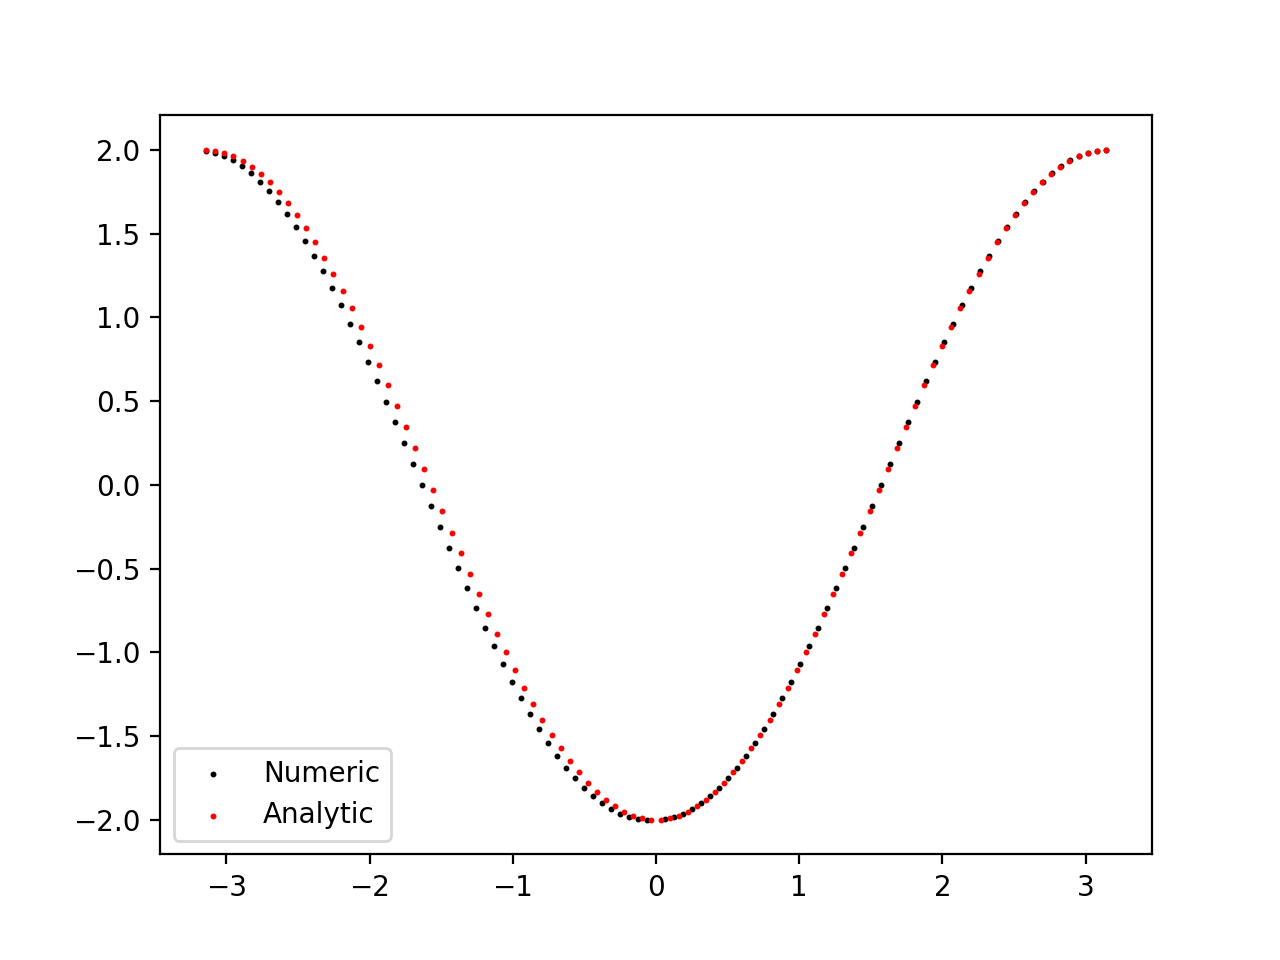

In [52]:
plt.figure()
plt.scatter(k_rec,eigs,marker='.',s=5,c='k',label='Numeric')
plt.scatter(ks,E_k, marker='.',s=5,c='r',label='Analytic')
plt.legend()
plt.show()

Yes we can!

Open questions:
- Bulk or boundary? How do we impose cutoff w/o these -t terms in the corners?
- Difference between this and what we did previously, which was to have a $k$ dependent matrix and calculate eigenvalues as a function of $k$? Perhaps this will become more apparent as we move on.

## 2D lattice

We now look at the 2D lattice model. We'll do a partial FT, leaving the x direction in real space.

$$\begin{equation}
H = -t \sum_x 2 \cos k_y c^{\dagger}_{x,k_y} c_{x,k_y} + c^{\dagger}_{x+1,k_y} c_{x,k_y} + c^{\dagger}_{x,k_y} c_{x+1,k_y}
\end{equation}$$

We know from Fourier analysis that the energy spectrum will be of the form $$ E_{k_x, k_y} = -2t \space (\cos k_x + \cos k_y) $$

<IPython.core.display.Javascript object>


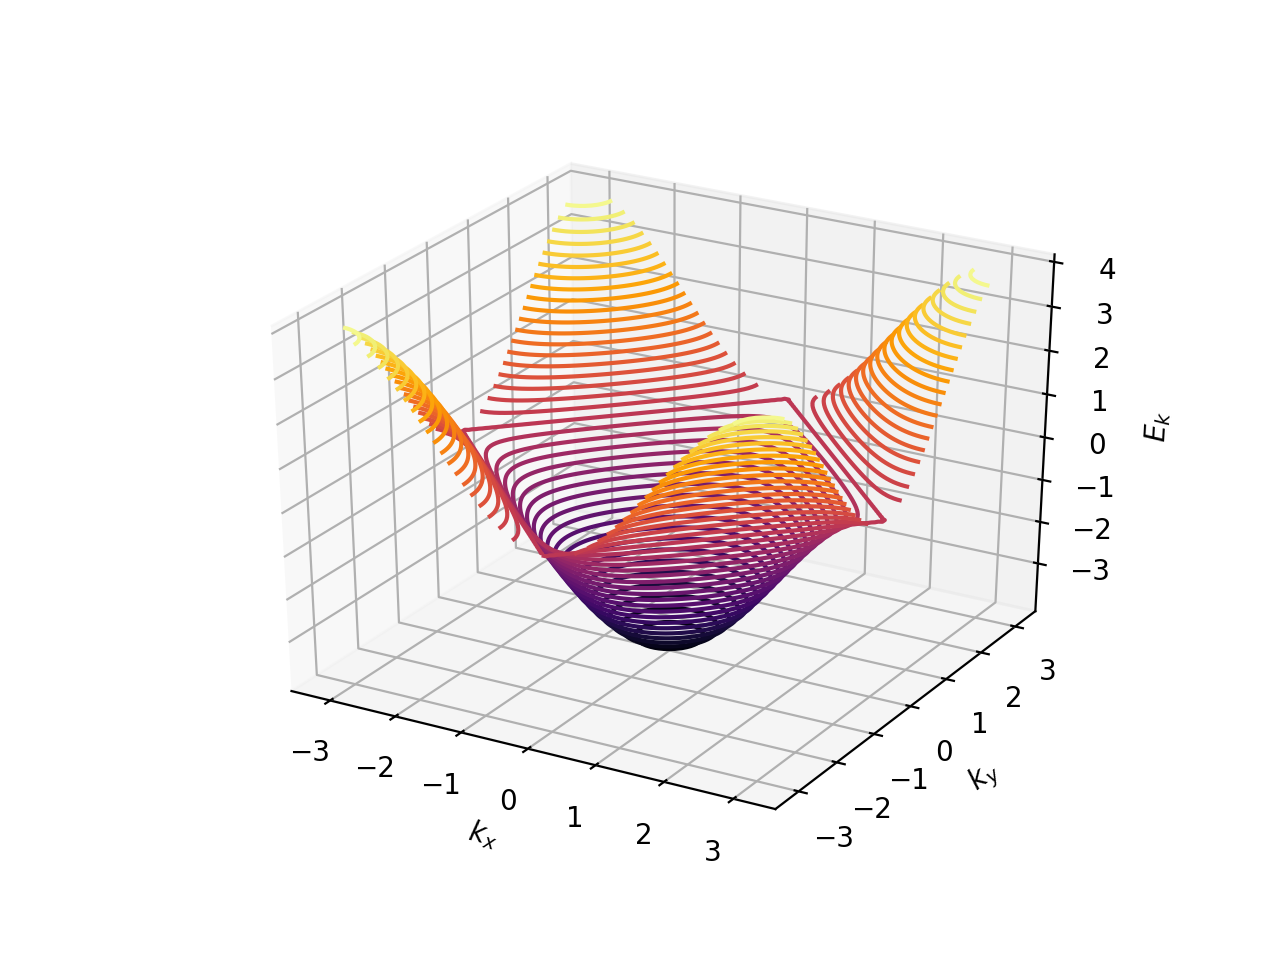

In [120]:
k_x = linspace(-pi,pi,num=100,endpoint=True)
k_y = linspace(-pi,pi,num=100,endpoint=True)

K_x, K_y = meshgrid(k_x,k_y)
E_k = -2 * (cos(K_x) + cos(K_y))

from mpl_toolkits import mplot3d

plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(K_x, K_y, E_k, 50, cmap='inferno')
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')
ax.set_zlabel(r'$E_k$')
plt.show()

<IPython.core.display.Javascript object>


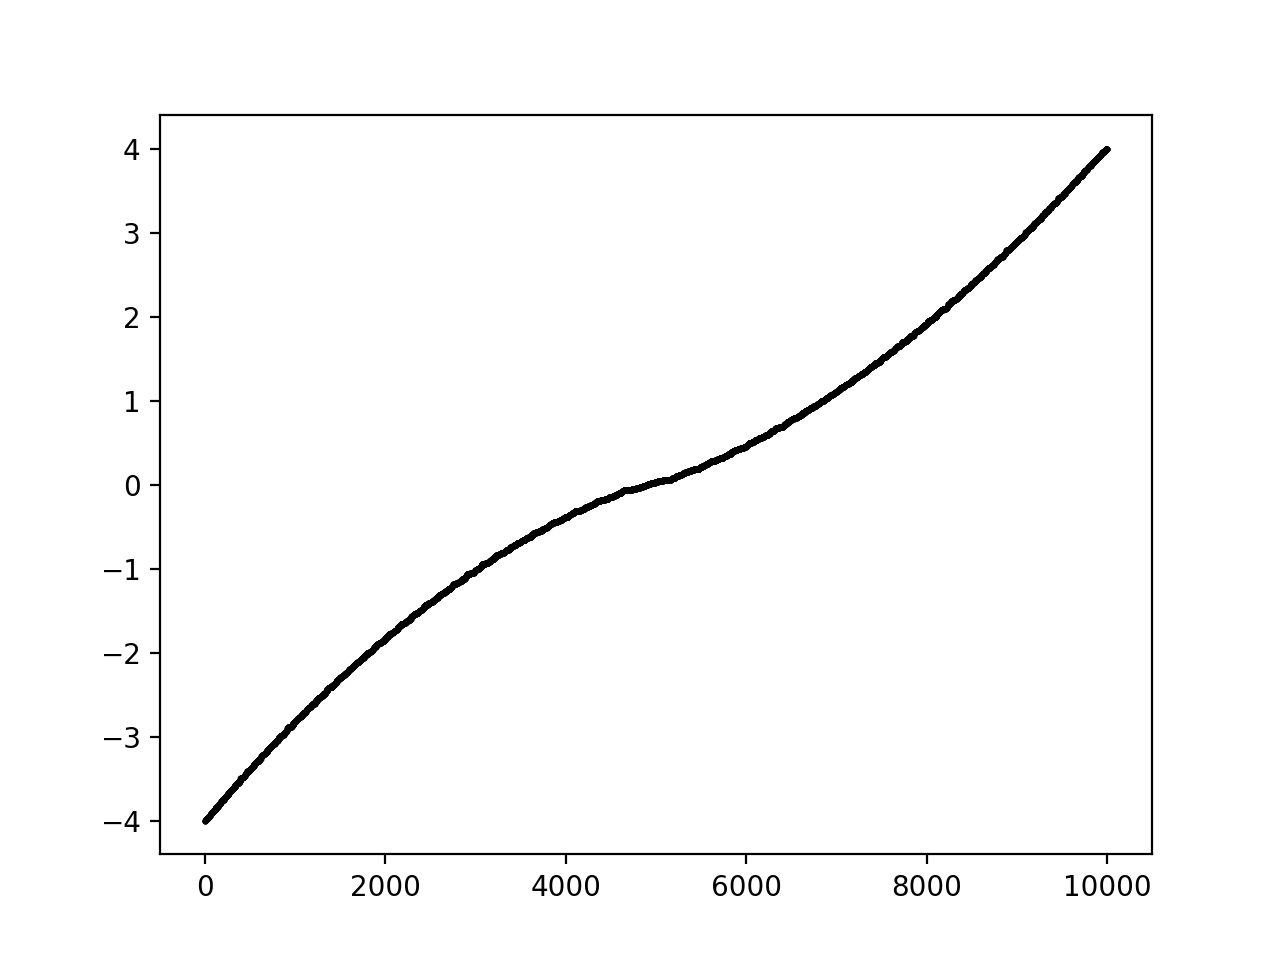

In [129]:
# once again, sort the energies to get something comparable
E_k_flat = sort(ndarray.flatten(E_k))

# plot it
plt.figure()
plt.scatter(linspace(1,len(E_k_flat),num=len(E_k_flat),endpoint=True),E_k_flat,c='k',marker='.',s=5)
plt.show()

To investigate this numerically we let $H$ will be diagonal in $k_y$ and use the real space represtantion of $x$ (i.e partial transform in $y$). It will have a familiar form within those block diagonals. 

In [91]:
def nu_block(size,nu,t=1):
    """
    Matrix to go in diagonal of 2D model
    """
    # diags
    diags = diag([2*cos(nu)]*size)
    nsh = diag(-t*ones(size-1), k=1) + diag(-t*ones(size-1), k=-1)
    M = diags + nsh
    M[0,size-1] = -t
    M[size-1,0] = -t
    return M

def H_mat_2D(size,t=1):
    """
    2D Hamiltonian matrix partially FT in y with dimensions N_x*N_y x N_x*N_y
    """
    # make block to go in diagonal
    blocks = zeros((size,size,size))
    nus = linspace(-pi,pi,size,endpoint = True)
    for i in range(size):
        nu = nus[i]
        blocks[i,:,:] = nu_block(size,nu=nu,t=t)
        
    # use sparse.block_diag instead of scipy.ditto because it takes in an array
    H = ss.block_diag(blocks).toarray() # <- still needs testing
    return H

In [ ]:
# calculate the eigenvalues and plot them
N_2 = 100
H_2D = H_mat_2D(size=N_2)
eigs_2D = ssl.eigsh(H_2D, k = int(N_2**2), return_eigenvectors=False) # <- recall H is N**2 x N**2
eigs_2D = sort(eigs_2D)

<IPython.core.display.Javascript object>


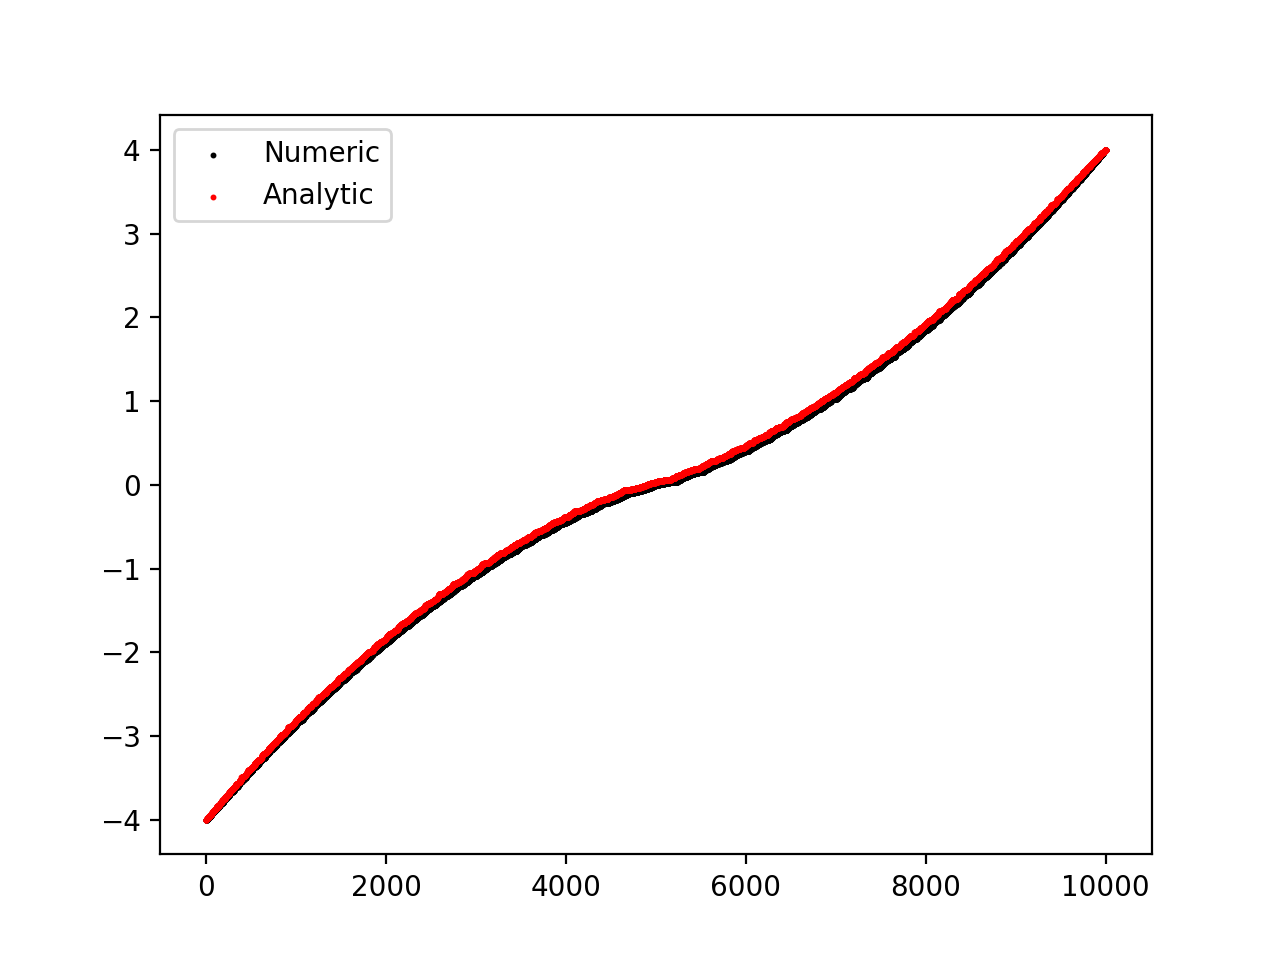

In [137]:
ns_2 = linspace(1,N_2**2,num=N_2**2,endpoint=True)

plt.figure()
plt.scatter(ns_2,eigs_2D,c='k',marker='.',s=5,label='Numeric')
plt.scatter(linspace(1,len(E_k_flat),num=len(E_k_flat),endpoint=True),E_k_flat,
            c='red',marker='.',s=5, label = 'Analytic')
plt.legend()
plt.show()

Can we recover $k$'s from `ns_2`?

In [190]:
size_rec = int(N_2**2)
k_x_rec = zeros(size_rec)
k_y_rec = zeros(size_rec)

for i in range(size_rec):
    n_new = ceil(i/2)
    k_x_rec[i] = (-1)**i * n_new * 2*pi / size_rec
    k_y_rec[i] = (-1)**i * n_new * 2*pi /size_rec

In [208]:
k_x_rec_plus = k_x_rec[k_x_rec >= 0]
k_x_rec_minus = k_x_rec[k_x_rec < 0]

<IPython.core.display.Javascript object>


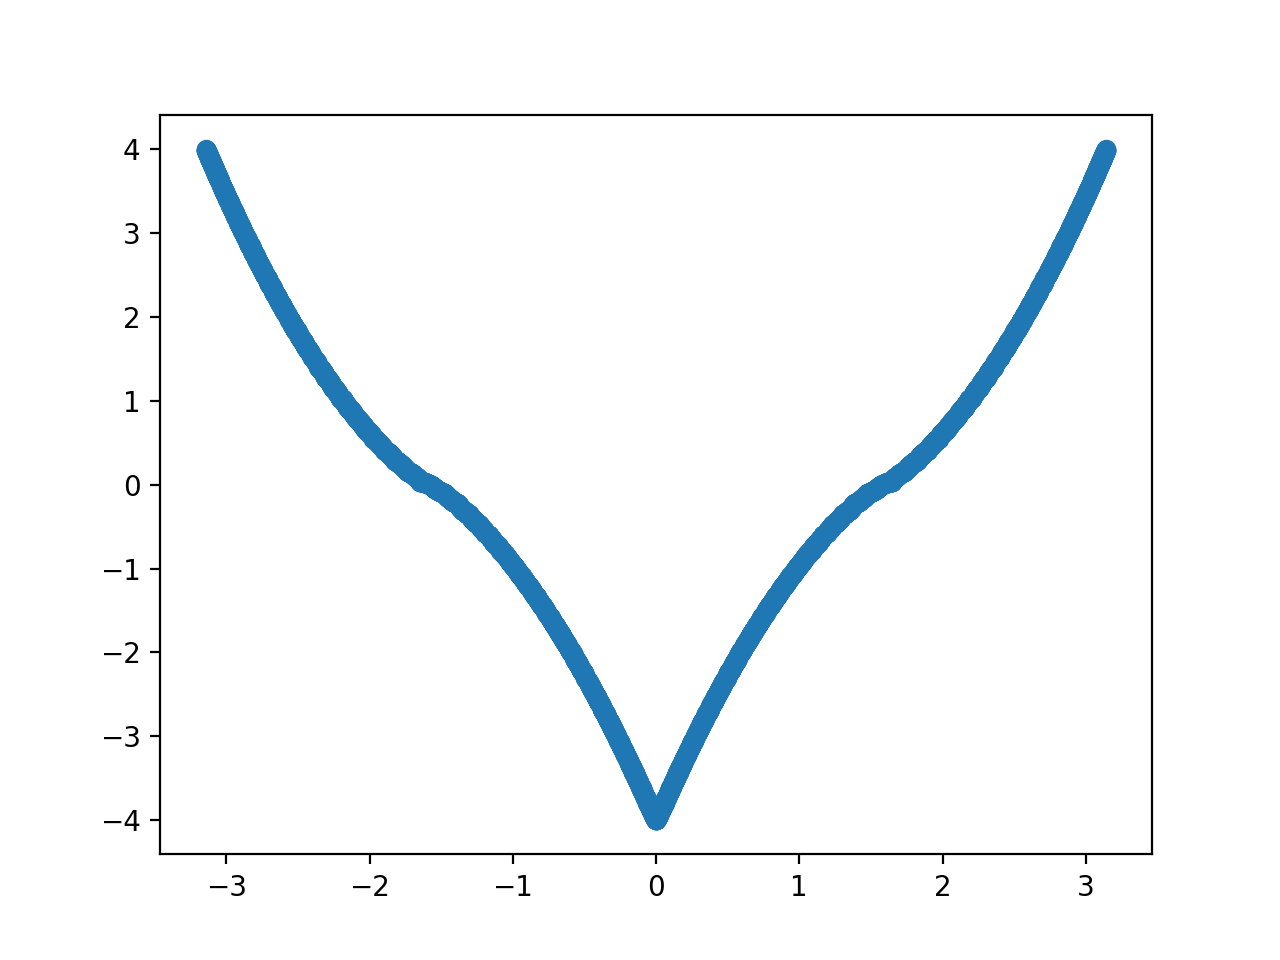

In [193]:
plt.figure()
plt.scatter(k_x_rec,eigs_2D)
plt.show()

In [210]:
eigs_2D_rec = reshape(eigs_2D,(N_2,N_2))

<IPython.core.display.Javascript object>


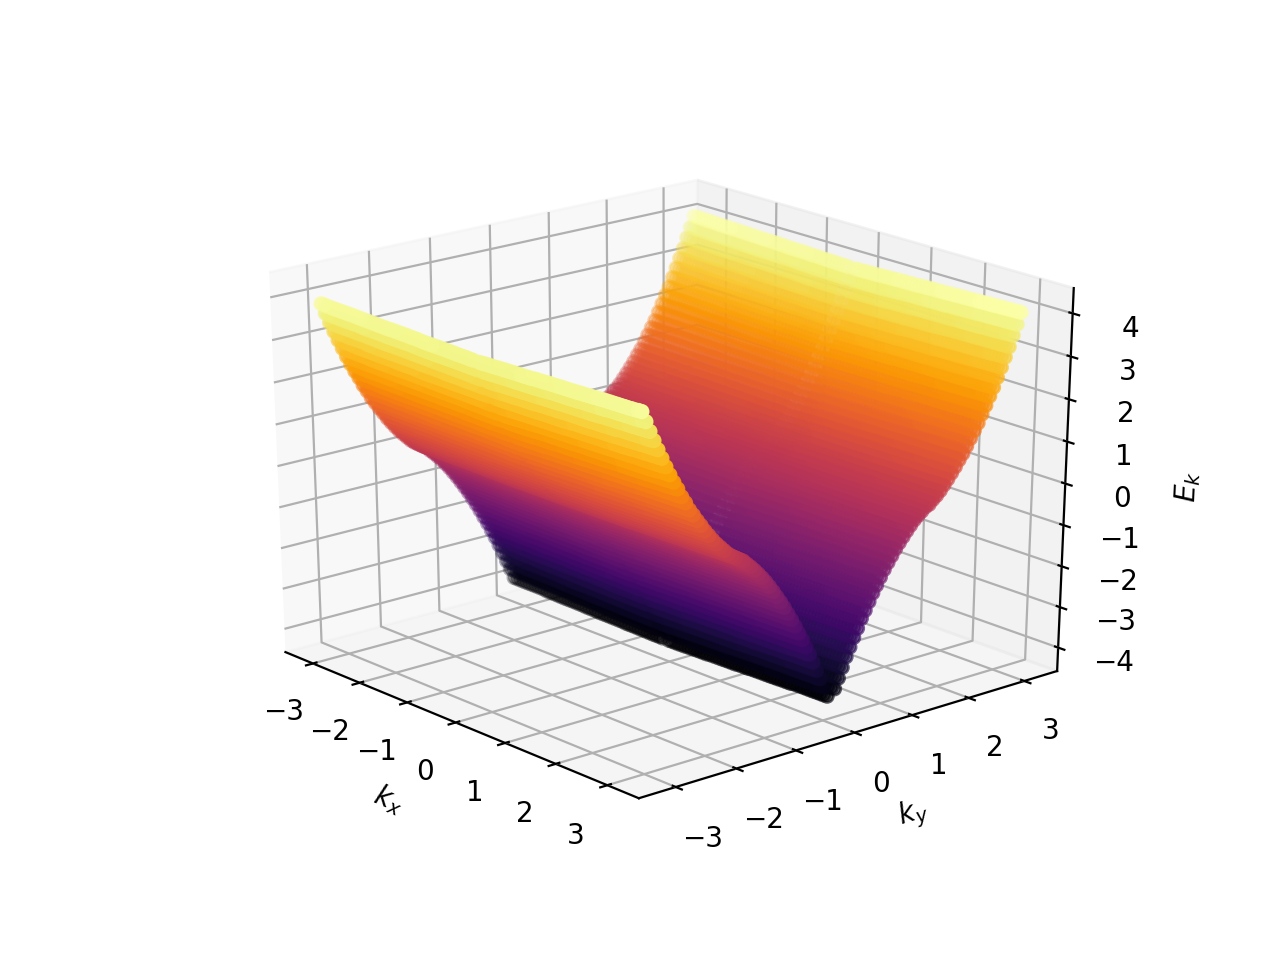

In [211]:
plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(K_x_rec, K_y_rec, eigs_2D_rec, c=eigs_2D, cmap='inferno')
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')
ax.set_zlabel(r'$E_k$')
plt.show()

Needs some work. Could be not worth pursuing.

## 2D lattice with $B$ (Peierls)

This is the same as the 2D lattice but now there is a gauge field $\vec{A} = Bx\hat{y}$. This leads to the Peierls substitution

$$ k_y \rightarrow k_y - \frac{By}{\phi_0}$$

How will this affect the Hamiltonian?
